In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

In [2]:
train = pd.read_excel('Data_Train.xlsx')
test = pd.read_excel('Data_Test.xlsx')

In [3]:
train.shape

(12690, 9)

In [4]:
test.shape

(4231, 8)

In [5]:
train.columns

Index(['TITLE', 'RESTAURANT_ID', 'CUISINES', 'TIME', 'CITY', 'LOCALITY',
       'RATING', 'VOTES', 'COST'],
      dtype='object')

In [6]:
train.COST.describe()

count    12690.000000
mean       655.252246
std        627.003540
min         20.000000
25%        300.000000
50%        500.000000
75%        800.000000
max      14000.000000
Name: COST, dtype: float64

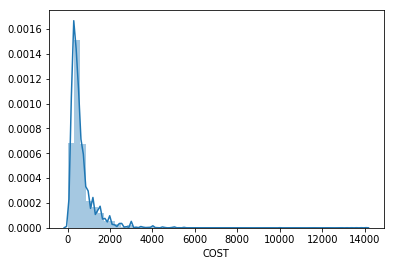

In [7]:
sns.distplot(train['COST'])
plt.show()

In [11]:
train.COST.skew()


3.9788007578247573

In [10]:
print('Kurtosis is %f' % train['COST'].kurt())

Kurtosis is 34.065257


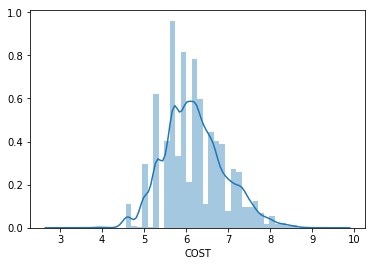

In [12]:
#using log transformation
target = np.log(train.COST)
sns.distplot(target)
plt.show()

In [13]:
print("Skew: %f" % target.skew())
print("Kurtosis : %f" % target.kurt())

Skew: 0.392350
Kurtosis : 0.168113


In [26]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

RESTAURANT_ID    int64
COST             int64
dtype: object

In [27]:
corr = numeric_features.corr()

In [28]:
print(corr['COST'].sort_values(ascending = False)[:5] ,'\n')
print(corr['COST'].sort_values(ascending = False)[-5:])


COST             1.00000
RESTAURANT_ID    0.04071
Name: COST, dtype: float64 

COST             1.00000
RESTAURANT_ID    0.04071
Name: COST, dtype: float64


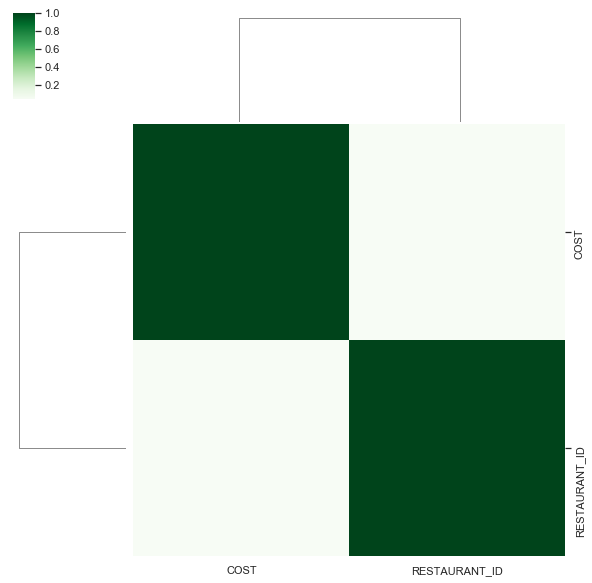

In [29]:
#correlation matric
k = 20
cols = corr.nlargest(k, 'COST')['COST'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale = 1.00)
hm = sns.clustermap(cm, cmap = "Greens", cbar = True, square = True, 
                    yticklabels = cols.values,  xticklabels = cols.values)

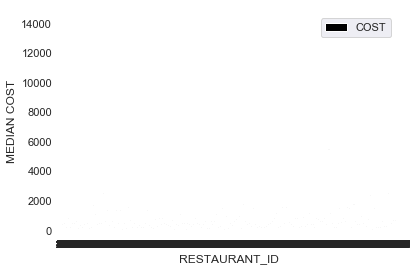

In [30]:
quality = train.pivot_table(index= 'RESTAURANT_ID', values = 'COST', aggfunc=np.median)
quality.plot(kind = 'bar', color ="black")
plt.xlabel('RESTAURANT_ID')
plt.ylabel('MEDIAN COST')
plt.xticks(rotation = 0)
plt.show()


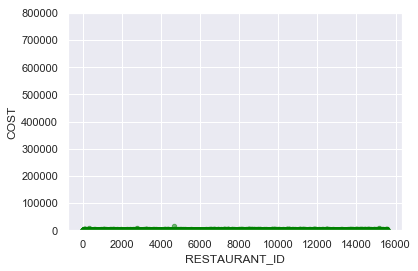

In [31]:
RI = pd.concat([train['COST'], train['RESTAURANT_ID']], axis = 1)
RI.plot.scatter(x ='RESTAURANT_ID', y= 'COST', ylim = (0,800000), c= 'green', alpha = 0.5)

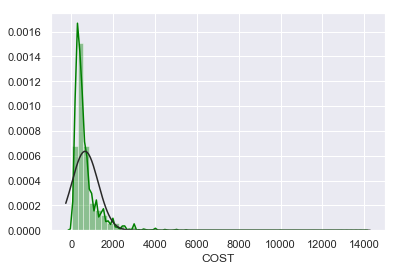

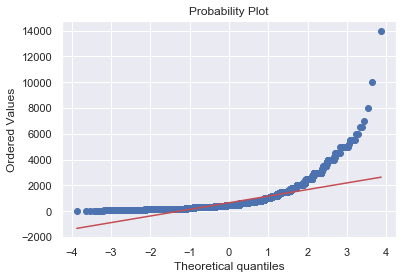

In [37]:
#histogram and probability plots
sns.distplot(train['COST'], fit = norm, color = 'Green')
fig= plt.figure()
res = stats.probplot(train['COST'], plot = plt)


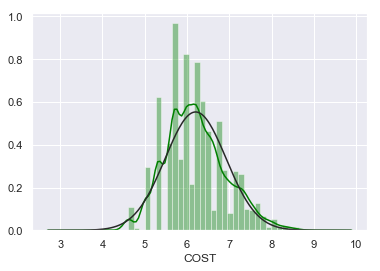

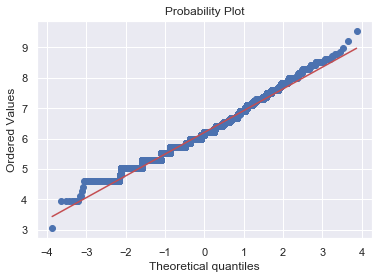

In [38]:
train['COST']= np.log1p(train['COST'])
sns.distplot(train['COST'], fit = norm, color = 'green')
fig = plt.figure()
res = stats.probplot(train['COST'],plot = plt)

In [39]:
#missing data
total = train.isnull().sum().sort_values(ascending = False)

percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)

missing_data = pd.concat([total,percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
VOTES,1204,0.094878
CITY,112,0.008826
LOCALITY,98,0.007723
RATING,2,0.000158
COST,0,0.000000
TIME,0,0.000000
CUISINES,0,0.000000
RESTAURANT_ID,0,0.000000
TITLE,0,0.000000


In [40]:
categorical_variables = train.select_dtypes(exclude=[np.number])
categorical_variables.describe()

##for c in categoricals.columns:##
    #print('{:<14}'.format(c), train[c].unique())##

,TITLE,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
count,12690,12690,12690,12578,12592,12688,11486
unique,113,4155,2689,359,1416,32,1847
top,QUICK BITES,South Indian,11am – 11pm (Mon-Sun),Chennai,Gachibowli,3.9,44 votes
freq,4218,532,1415,2174,166,1238,71


In [42]:
#feature_engineering

columns = ('TITLE', 'RESTAURANT_ID', 'CUISINES', 'TIME', 'CITY', 'LOCALITY',
       'RATING', 'VOTES')

for i in columns:
    lbl = LabelEncoder() 
    lbl.fit(list(train[i].values)) 
    train[i] = lbl.transform(list(train[i].values))
    lbl.fit(list(test[i].values)) 
    test[i] = lbl.transform(list(test[i].values))

In [44]:
#preparing for model fitting
train=train.drop(columns=['CITY', 'LOCALITY', 'VOTES', 'RATING', 'TIME'])
test=test.drop(columns=['CITY', 'LOCALITY', 'VOTES', 'RATING', 'TIME'])

In [45]:
train = train.dropna(thresh=0.70*len(train), axis=1)
test = test.dropna(thresh=0.70*len(test), axis=1)

data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [47]:
y = train.COST
X = data.drop(['COST','RESTAURANT_ID'], axis =1)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,  random_state =1)

In [50]:
#Linear Regression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)
print('The accuracy of the Linear Regression is',r2_score(y_test,y_pred))
print ('RMSE is: ', mean_squared_error(y_test, y_pred))

submission = pd.DataFrame()
submission['RESTAURANT_ID'] = test.RESTAURANT_ID

feats = test.select_dtypes(
        include=[np.number]).drop(['RESTAURANT_ID'], axis=1).interpolate()

predictions = lm.predict(feats)

lm_predictions = np.exp(predictions)


print ("Original predictions are: \n", predictions[:5], "\n")
print ("Final predictions are: \n", lm_predictions[:5])

submission['cost'] = lm_predictions
submission.head()

submission.to_csv('Linear Regression.csv', index=False)

The accuracy of the Linear Regression is 0.10684133332917489
RMSE is:  132.07092566122662
Original predictions are: 
 [27.19958374 20.43326275 27.30515211 20.71463245 20.43652103] 

Final predictions are: 
 [6.49574738e+11 7.48261255e+08 7.21899744e+11 9.91403775e+08
 7.50703278e+08]


In [51]:
lambda_values = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.03, 10, 30, 50, 100, 150, 300, 500, 1001]

from sklearn.linear_model import Lasso

def train_lasso(X, Y, alpha):
    lasso = Lasso(alpha=alpha, max_iter=1000)
    lasso = lasso.fit(X, Y)
    return lasso
lasso_models = []

for alpha in lambda_values:
    l = train_lasso(X_train, y_train, alpha)
    lasso_models.append(l)
    
for i, alpha in enumerate(lambda_values):
    print('Lambda value: ',alpha)
    y_pred_lasso = lasso_models[i].predict(X_test)
    print('The accuracy of the Lasso Regression is',r2_score(y_test,y_pred_lasso))
    print ('RMSE is: ', mean_squared_error(y_test, y_pred_lasso))
    print('\n')
    
    submission = pd.DataFrame()
submission['RESTAURANT_ID'] = test.RESTAURANT_ID


features = test.select_dtypes(
        include=[np.number]).drop(['RESTAURANT_ID'], axis=1).interpolate()

lasso_predictions = lasso_models[1].predict(features)
final_lasso = np.exp(lasso_predictions)

print ("Original predictions are: \n", lasso_predictions[:5], "\n")
print ("Final lasso predictions are: \n", final_lasso[:5])

submission['COST'] = final_lasso
submission.head()

submission.to_csv('lasso.csv', index=False)

Lambda value:  1e-05
The accuracy of the Lasso Regression is 0.10684133479022495
RMSE is:  132.07092544518187


Lambda value:  0.0001
The accuracy of the Lasso Regression is 0.10684134795725331
RMSE is:  132.07092349817995


Lambda value:  0.001
The accuracy of the Lasso Regression is 0.10684147988990478
RMSE is:  132.07090398936472


Lambda value:  0.005
The accuracy of the Lasso Regression is 0.10684206301262156
RMSE is:  132.07081776330003


Lambda value:  0.01
The accuracy of the Lasso Regression is 0.1068428029515488
RMSE is:  132.07070834890067


Lambda value:  0.03
The accuracy of the Lasso Regression is 0.10684571388457909
RMSE is:  132.0702779106883


Lambda value:  10
The accuracy of the Lasso Regression is 0.10761485595822484
RMSE is:  131.95654525665717


Lambda value:  30
The accuracy of the Lasso Regression is 0.10505370841132933
RMSE is:  132.33526086441617


Lambda value:  50
The accuracy of the Lasso Regression is 0.09701500272917307
RMSE is:  133.52394025608334


Lamb

In [52]:
submission['COST'] = final_lasso
submission.head()

,RESTAURANT_ID,COST
0,1085,6.495728e+11
1,3374,7.482628e+08
2,347,7.218975e+11
3,42,9.914059e+08
4,3567,7.507048e+08
